# IMPORT

In [1]:
import torch
from transformers import AutoModel, AutoTokenizer
from pprint import pprint
from helpers.tesseract_utils import Tesseract
import pandas as pd
import cv2
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from helpers import text_utils
from helpers import es_utils
from helpers import image_utils
from helpers import scanner
from elasticsearch import Elasticsearch
from sklearn.utils import shuffle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.figure()

2021-07-21 23:22:59.722147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-21 23:22:59.722196: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package punkt to /home/pot/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [2]:
LEN_FEATURE = 768
LEN_TOKEN = 140
INDEX_NAME = 'image-classify'
ES_HOST = '10.1.32.130'
ES_PORT = '9200'
PATH_DATASET = './datasets/image_classify/main.xlsx'
PATH_TEST = './datasets/image_classify/test.xlsx'

CLASSES = {
    1: 'discharge record',
    2: 'driver licence',
    3: 'invoice',
    4: 'resume',
    5: 'vehicle certificate',
    6: 'degree of bachelor'
    
}

STOPWORDS = set([
    '\\', '(', ')', ':', '.', ';', ',', '\\\\', '\\\\\\', '-', '%', '`', '—-', '?', '——', '--', '@',  '[', ']', '.....', '``', 'đụ', 'đéo'
#     'cộng', 'hòa', 'xã', 'hội', 'chủ', 'nghĩa', 'việt', 'nam', 'độc', 'lập', 'tự', 'do', 'hạnh', 'phúc'
])

# Load Model

In [3]:
phobert = AutoModel.from_pretrained("models/phobert-base")
tokenizer = AutoTokenizer.from_pretrained("models/phobert-base")
tesseract = Tesseract(out_type='string')
es = Elasticsearch([{'host': ES_HOST, 'port': ES_PORT}])
scanner = scanner.ScannerFindContours()


def get_class_name(class_id):
    return CLASSES[class_id]

Some weights of the model checkpoint at models/phobert-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


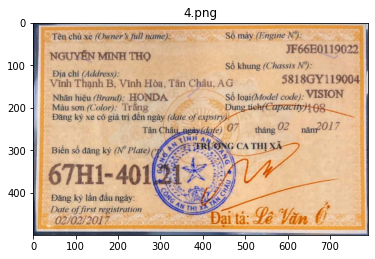

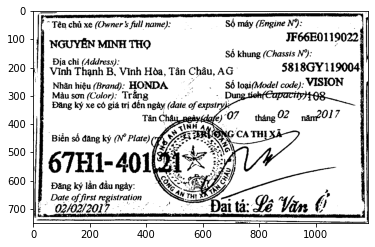

['tên', 'chủ', 'xe', 'wner', 'u', 'sộ', 'máy', 'engine', 'mmm', 'c', 'ì', 'nguyên', 'minh', 'thọ', 'l', 'số', 'khung', 'chassis', '¡', 'địa', 'chỉ', 'vĩnh', 'thạnh', 'vĩnh', 'hòa', 'tân', 'châu', 'ag', 'honda', 'sốlogiamodelcode', 'vision', 'ê', 'màusơn', 'color', 'trắng', 'dungúehfœtngpdchy', '†os', 'đăng', 'ký', 'xe', 'có', 'giá', 'trị', 'đến', 'ngày', 'daie', 'oƒ', 'expsiry', 'z', 'tânỏ', 'creày', 'ì', 'ị', '„', 'r', 'ca', 'thị', 'ì', 'í', 'biển', 'số', 'đăng', 'ký', 'plate', 's', '’', 'đăng', 'ký', 'lằn', 'đầu', 'ngà', 'q', '’', 'v\\', 'y', 'x', 'á', 'date', 'offirst', 'registration', 'x', 'ũ', 'ố', 'ozxzế', 'nh', 'lii', 'tá', 'v']
tensor([ 0.2247,  0.1496, -0.1109, -0.4253,  0.0170])


In [4]:
giay_ra_vien = image_utils.load_datasets('./datasets/image_classify/images/giay_ra_vien/')
giay_phep_lai_xe = image_utils.load_datasets('./datasets/image_classify/images/giay_phep_lai_xe/')
hoa_don = image_utils.load_datasets('./datasets/image_classify/images/hoa_don/')
cv = image_utils.load_datasets('./datasets/image_classify/images/cv/')
cavet_xe_may = image_utils.load_datasets('./datasets/image_classify/images/cavet_xe_may/')
# result_covid_test = image_utils.load_datasets('./datasets/image_classify/images/result_covid_test/')
bang_dai_hoc = image_utils.load_datasets('./datasets/image_classify/images/bang_dai_hoc/')

image = scanner.process(image_utils.load(cavet_xe_may[2]))
# mask, image = image_utils.get_title(image)
plt.imshow(image)
plt.title(giay_ra_vien[0].split('/')[-1])
plt.show()


image = image_utils.pre_process(image)
plt.imshow(image, cmap = 'gray')
# plt.title(giay_ra_vien[0].split('/')[-1])
plt.show()


text = tesseract.excecute(image)    
tokens = word_tokenize(text_utils.text_cleaner(text))
tokens = text_utils.fix_tokens(tokens, STOPWORDS)
print(tokens[0:140])


if len(tokens) >= LEN_TOKEN:
    tokens = tokens[0:LEN_TOKEN]
else:
    for i in range(len(tokens) - LEN_TOKEN):
        tokens.append('None')
input_ids = torch.tensor([tokenizer.encode(tokens)])
with torch.no_grad():
    features = phobert(input_ids) 
es_dim = features['pooler_output'][0].tolist()
print(features['pooler_output'][0][0:5])

In [5]:
# image_1 = image_utils.pre_process(scanner.process(image_utils.load(giay_ra_vien[0])))
# image_2 = image_utils.pre_process(scanner.process(image_utils.load(giay_phep_lai_xe[0])))
# image_3 = image_utils.pre_process(scanner.process(image_utils.load(hoa_don[0])))
# image_4 = image_utils.pre_process(scanner.process(image_utils.load(cv[0])))
# image_5 = image_utils.pre_process(scanner.process(image_utils.load(cavet_xe_may[0])))
# image_6 = image_utils.pre_process(scanner.process(image_utils.load(bang_dai_hoc[0])))


# cv2.imwrite('1.png', image_1)
# cv2.imwrite('2.png', image_2)
# cv2.imwrite('3.png', image_3)
# cv2.imwrite('4.png', image_5)
# cv2.imwrite('5.png', image_5)
# cv2.imwrite('6.png', image_6)

In [ ]:
# hoa_don_tien_dien = image_utils.load_datasets('./datasets/image_classify/images/hoa_don/')

# for item in hoa_don_tien_dien:
#     print(item)
    
#     image = scanner.process(image_utils.load(item))
#     image = image_utils.pre_process(image)

# #     text = tesseract.excecute(image)    
# #     tokens = word_tokenize(text_utils.text_cleaner(text))
# #     tokens = text_utils.fix_tokens(tokens, STOPWORDS)
# #     print(tokens[0:7])
#     plt.imshow(image, cmap = 'gray')
#     plt.title(item.split('/')[-1])
#     plt.show()

# Train and Val

Text(0, 0.5, 'Total Sample')

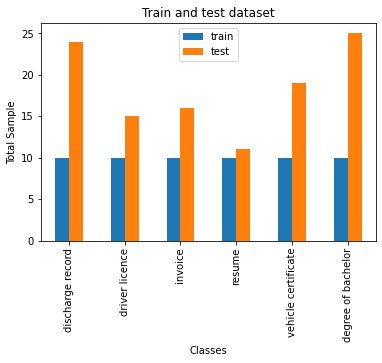

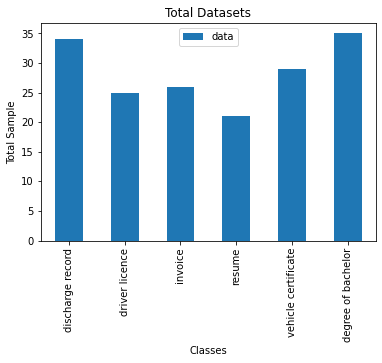

In [7]:
def make_data(data: list, list_data, class_id):
    for item in list_data:
        data.append([item, class_id])
    return data
        
columns = ['image','class']
data_test = []
make_data(data_test, giay_ra_vien[10:], 1)
make_data(data_test, giay_phep_lai_xe[10:], 2)
make_data(data_test, hoa_don[10:], 3)
make_data(data_test, cv[10:], 4)
make_data(data_test, cavet_xe_may[10:], 5)
make_data(data_test, bang_dai_hoc[10:], 6)

data_train = []
make_data(data_train, giay_ra_vien[0:10], 1)
make_data(data_train, giay_phep_lai_xe[0:10], 2)
make_data(data_train, hoa_don[0:10], 3)
make_data(data_train, cv[0:10], 4)
make_data(data_train, cavet_xe_may[0:10], 5)
make_data(data_train, bang_dai_hoc[0:10], 6)



# df_show = pd.DataFrame(data_train, columns=columns)
# df_show['class'] = df_show['class'].apply(get_class_name)
# df_show['class'].value_counts().plot(kind="bar", title="Number train of class")
# plt.show()
# df_show = pd.DataFrame(data_test, columns=columns)
# df_show['class'] = df_show['class'].apply(get_class_name)
# df_show['class'].value_counts().plot(kind="bar", title="Number test of class")
# plt.show()


from sklearn.utils import shuffle
df_train = pd.DataFrame(data_train, columns=columns)
df_train = shuffle(df_train).reset_index(drop=True)
df_train['type'] = ['train' for i in range(df_train.shape[0])]

df_test = pd.DataFrame(data_test, columns=columns)
df_test = shuffle(df_test).reset_index(drop=True)
df_test['type'] = ['test' for i in range(df_test.shape[0])]

frames = [df_train, df_test]
df = pd.concat(frames)


def get_list_class(classes):
    return [value for key, value in classes.items()]


# make chart
df_train_sum = df_train.groupby('class').count().reset_index(drop=True)
df_test_sum = df_test.groupby('class').count().reset_index(drop=True)
df_sum = df.groupby('class').count().reset_index(drop=True)


# df_sum['image'] = df_sum['image'].apply(lambda x: x/df.shape[0]*100)



X = get_list_class(CLASSES)
TRAIN = list(df_train_sum['image'])
TEST = list(df_test_sum['image'])

plotdata = pd.DataFrame({
    "train": TRAIN,
    "test":TEST,
    }, 
    index=X
)
plotdata.plot(kind="bar")
plt.title("Train and test dataset")
plt.xlabel("Classes")
plt.ylabel("Total Sample")

plotdata = pd.DataFrame({
    "data": list(df_sum['image']),
    }, 
    index=X
)
plotdata.plot(kind="bar")
plt.title("Total Datasets")
plt.xlabel("Classes")
plt.ylabel("Total Sample")

In [26]:
es_utils.delete_elasticsearch_index(es, INDEX_NAME)
es_utils.create_elasticsearch_index(es, INDEX_NAME, LEN_FEATURE)

df = df_train
len_list_task = len(df['image'])
index = 1
pbar = tqdm(total=len_list_task,  position=0, leave=False)

for i in range(len_list_task):
    
    image_path = df['image'][i]
    class_id = df['class'][i]
    image = image_utils.load(image_path)
    image = scanner.process(image)
    image = image_utils.pre_process(image)
    text = tesseract.excecute(image)

    tokens = word_tokenize(text_utils.text_cleaner(text))
    tokens = text_utils.fix_tokens(tokens, STOPWORDS)
    if len(tokens) >= LEN_TOKEN:
        tokens = tokens[0:LEN_TOKEN]
    else:
        for i in range(len(tokens) - LEN_TOKEN):
            tokens.append('None')

    input_ids = torch.tensor([tokenizer.encode(tokens)])
    with torch.no_grad():
        features = phobert(input_ids) 
    es_dim = features['pooler_output'][0].tolist()
    es_utils.create_elasticsearch_datasets(es, INDEX_NAME, class_id, CLASSES[class_id] ,image_path, es_dim, index)
    index += 1
    pbar.update(1)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [02:22<00:00,  2.32s/it]

In [ ]:
from sklearn.metrics import confusion_matrix
import time
start_time = time.time()


df =df_test
x = 0
# confusion_matrix = np.zeros((len(CLASSES), len(CLASSES)))

y_actu = []
y_pred = []

for i in range(len(df['image'])):
    image_path = df['image'][i]
    class_id = df['class'][i]
    
    image = scanner.process(image_utils.load(image_path))
    image = image_utils.pre_process(image)
    text = tesseract.excecute(image)
 
    tokens = word_tokenize(text_utils.text_cleaner(text))
    tokens = text_utils.fix_tokens(tokens, STOPWORDS)
        
    if len(tokens) >= LEN_TOKEN:
        tokens = tokens[0:LEN_TOKEN]
    else:
        for i in range(len(tokens) - LEN_TOKEN):
            tokens.append('None')
    input_ids = torch.tensor([tokenizer.encode(tokens)])
    with torch.no_grad():
        features = phobert(input_ids) 
    es_dim = features['pooler_output'][0].tolist()
    pred = es_utils.matching_elasticsearch_index(es, INDEX_NAME, es_dim)
   
    hits = pred['hits']['hits']
    class_pre = hits[0]['_source']['id']
    
    y_actu.append(class_id)
    y_pred.append(class_pre)
    
    if class_id == class_pre:
        x += 1
    else:
        print(image_path, class_pre, class_id)
#     confusion_matrix[class_id -1, class_pre -1] += 1
    print("--- %s seconds ---" % (time.time() - start_time))
    
print(x/len(df['image']))

# #     df_check = pd.json_normalize(hits)
# #     df_check = df_check[['_source.id', '_score']]
# #     df_check = df_check.rename(columns = {'_source.id': 'id', '_score': 'score'})
# #     df_check = df_check.groupby(["id"], as_index=False).mean()
# #     class_pre = df_check.loc[df_check['score'].idxmax()]['id']

df_show= df['class'].apply(get_class_name)
df_show.value_counts().plot(kind="bar", title="Number of Test Data")


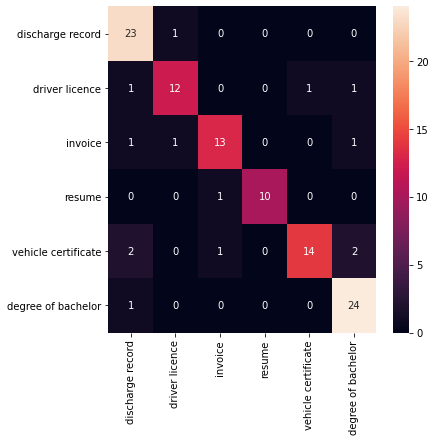

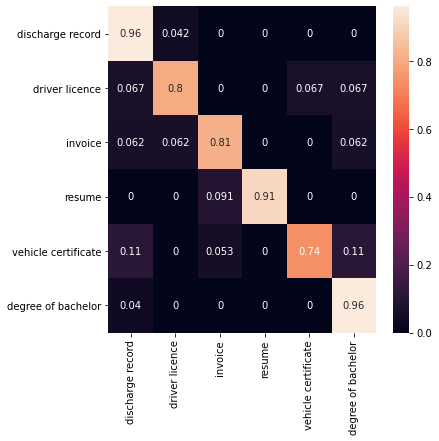

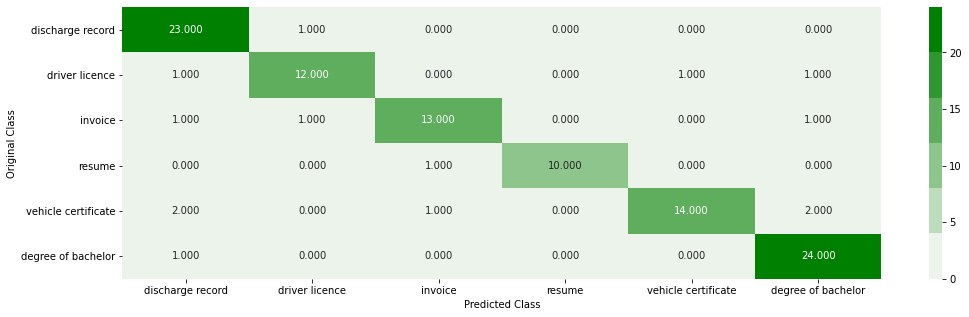

-------------------------------------------------- Confusion matrix --------------------------------------------------


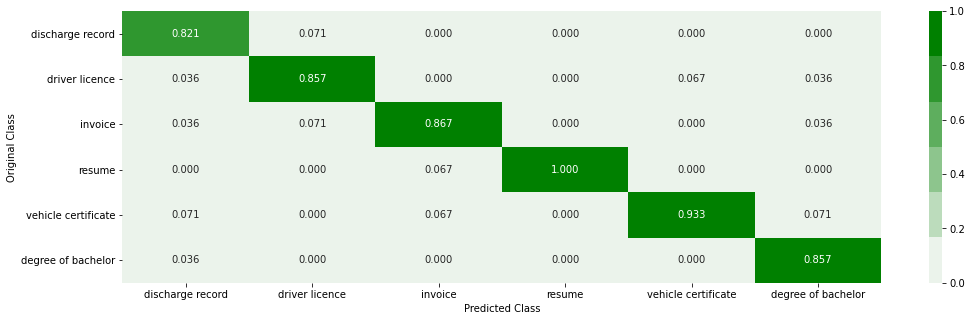

-------------------------------------------------- Precision matrix --------------------------------------------------


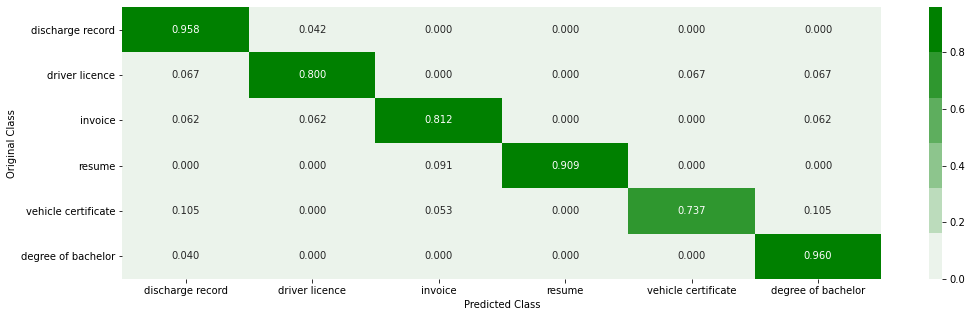

-------------------------------------------------- Recall matrix --------------------------------------------------


In [15]:
import seaborn as sn
import numpy as np
y = confusion_matrix(y_actu, y_pred)
columns = []
for key, value in CLASSES.items():
    columns.append(value)
y = y.astype(np.float32)
df_cm = pd.DataFrame(y, index = columns,
                     columns =  columns)
plt.figure(figsize = (len(CLASSES), len(CLASSES)))
sn.heatmap(df_cm, annot=True)

for i in range(len(CLASSES)):
    total = sum(y[i])
    for j in range(len(CLASSES)):
        y[i][j] = y[i][j]/total
df_cm = pd.DataFrame(y, index = columns,
                     columns =  columns)
plt.figure(figsize = (len(CLASSES), len(CLASSES)))
sn.heatmap(df_cm, annot=True)

import seaborn as sns
def plot_confusion_matrix(test_y, predict_y, classes):
    """
    This function plots the confusion matrix given predicted and actual values.
    """
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)    
    B =(C/C.sum(axis=0))
    labels = classes
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    plt.figure(figsize=(17,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*50, "Confusion matrix", "-"*50)

    plt.figure(figsize=(17,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*50, "Precision matrix", "-"*50)
    
#     print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    plt.figure(figsize=(17,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*50, "Recall matrix"    , "-"*50)
#     print("Sum of rows in precision matrix",A.sum(axis=1))
plot_confusion_matrix(y_actu, y_pred, classes)